In [4]:
# 동적 사이저로 백테스트 실행
from datetime import datetime

import backtrader as bt

from src.backtest.backtest_builder import BacktestBuilder
from src.backtest.commission_config import CommissionConfig
from src.backtest.data_feed import PandasDataFeedConfig
from src.backtest.data_feed.candle_loader import candles_to_dataframe, timeframe_to_korean
from src.backtest.sizer_config import SizerConfig
from src.backtest.strategy.ema_simple_alignment_strategy import EmaSimpleAlignmentStrategy
from src.container import ApplicationContainer

container = ApplicationContainer()

ticker_name = "KRW-BTC"

ticker_repository = container.ticker_repository()
ticker = ticker_repository.find_by_ticker(ticker_name)

repo = container.candle_daily_repository()
# repo = container.candle_hour1_repository()
candles = repo.get_candles(
    ticker_id=ticker.id,  # KRW-BTC
    start_datetime=datetime(2024, 1, 1)
)

# 2. DataFrame 변환 (타임프레임 자동 감지)
df, timeframe = candles_to_dataframe(candles)
config = PandasDataFeedConfig.create(df, name=ticker.ticker)

initial_cash = 100_000_000

result = (
    BacktestBuilder()
    .with_initial_cash(initial_cash)
    .with_slippage(0.001)
    .with_commission(CommissionConfig.stock(0.0005))

    # ================== 전략 ==================
    # Buy & Hold
    # .with_strategy(BuyAndHoldStrategy)

    # 단순 정배열
    .with_strategy(EmaSimpleAlignmentStrategy, ema_periods=(5, 20, 40))

    # 20,40 정배열 & 간격 & 기울기
    # .with_strategy(
    #     EmaAlignmentStrategy,
    #     min_gap=2.0,  # 최소 간격 (%)
    #     min_slope=1.0,  # 최소 기울기 (%)
    #     slope_period=5,  # 기울기 계산 기간
    # )

    # ================== 비중 ==================

    # 전체
    # .with_sizer(SizerConfig.all_in())
    .with_sizer(SizerConfig.percent(99))

    # 20, 40일 기울기 & 간격에 따라서 비중 조절
    # .with_sizer(SizerConfig.custom(EmaDynamicSizer,
    #                                slope_period=5,
    #                                max_slope=5.0,
    #                                max_gap=10.0,
    #                                min_weight=0.3,
    #                                max_weight=1.0
    #                                ))
    .add_data(config)
    .with_analyzer(bt.analyzers.SharpeRatio, "sharpe")
    .with_analyzer(bt.analyzers.DrawDown, "drawdown")
    .with_analyzer(bt.analyzers.TradeAnalyzer, "trades")
    .with_analyzer(bt.analyzers.Returns, "returns")
    .with_analyzer(bt.analyzers.SQN, "sqn")
    .run()
)


Starting Portfolio Value: 100000000.00
2024-02-09, BUY CREATE (롱 진입), Close: 63630000.00
2024-02-09, EMA5: 61082986.33, EMA20: 59287159.15, EMA40: 58856925.00
2024-02-10, BUY EXECUTED (롱 진입), Price: 63693630.00
2024-04-15, SELL CREATE (롱 청산), Close: 96689000.00
2024-04-15, EMA5: 98003515.61, EMA20: 98356620.43, EMA40: 95251984.09
2024-04-16, SELL EXECUTED (롱 청산), Price: 96592311.00
2024-04-29, SELL CREATE (숏 진입), Close: 89632000.00
2024-04-29, EMA5: 91232618.95, EMA20: 94097037.25, EMA40: 94103667.27
2024-04-30, SELL EXECUTED (숏 진입), Price: 89566344.00
2024-05-16, BUY CREATE (숏 커버), Close: 91448000.00
2024-05-16, EMA5: 89165021.79, EMA20: 89042310.70, EMA40: 90440619.42
2024-05-17, BUY EXECUTED (숏 커버), Price: 91566475.00
2024-05-22, BUY CREATE (롱 진입), Close: 96461000.00
2024-05-22, EMA5: 94570206.30, EMA20: 91416432.04, EMA40: 91406278.88
2024-05-23, BUY EXECUTED (롱 진입), Price: 96557461.00
2024-06-15, SELL CREATE (롱 청산), Close: 93775000.00
2024-06-15, EMA5: 95188130.34, EMA20: 9566281

In [5]:
# 리포트

print("\n" + "=" * 60)
print("📊 백테스트 결과")
print("=" * 60)

strategy = result[0]

# 데이터 기간
start_date = df.index[0]
end_date = df.index[-1]

print(f"\n📅 데이터 정보:")
print(f"   - 타임프레임: {timeframe_to_korean(timeframe)}")
print(f"   - 시작일: {start_date.strftime('%Y-%m-%d')}")
print(f"   - 종료일: {end_date.strftime('%Y-%m-%d')}")

# 샤프 비율
sharpe = strategy.analyzers.getbyname('sharpe').get_analysis()
print(f"\n📈 샤프 비율: {sharpe.get('sharperatio', 'N/A')}")

# 수익률
returns = strategy.analyzers.getbyname('returns').get_analysis()
final_value = strategy.broker.getvalue()
total_return = (final_value - initial_cash) / initial_cash * 100

# CAGR 계산 (연복리 수익률)
years = (end_date - start_date).days / 365.25
cagr = ((final_value / initial_cash) ** (1 / years) - 1) * 100

print(f"\n💰 수익률:")
print(f"   - 초기 자본: {initial_cash:,.0f}원")
print(f"   - 최종 금액: {final_value:,.0f}원")
print(f"   - 연복리 수익률 (CAGR): {cagr:.2f}%")
print(f"   - 투자 기간: {years:.1f}년")

# 최대 낙폭
drawdown = strategy.analyzers.getbyname('drawdown').get_analysis()
mdd_bars = drawdown.get('max', {}).get('len', 0)

# 타임프레임에 따라 일수 계산
if timeframe == "1m":
    mdd_days = mdd_bars / (60 * 24)  # 분 → 일
elif timeframe == "1h":
    mdd_days = mdd_bars / 24  # 시간 → 일
else:  # 1d
    mdd_days = mdd_bars

print(f"\n📉 최대 낙폭 (MDD):")
print(f"   - 최대 낙폭: {drawdown.get('max', {}).get('drawdown', 0):.2f}%")
print(f"   - 최대 낙폭 기간: {mdd_days:.1f}일 ({mdd_bars:,} bars)")

# 거래 분석
trades = strategy.analyzers.getbyname('trades').get_analysis()
total_trades = trades.get('total', {}).get('total', 0)
won = trades.get('won', {}).get('total', 0)
lost = trades.get('lost', {}).get('total', 0)

print(f"\n🔄 거래 분석:")
print(f"   - 총 거래 수: {total_trades}")
print(f"   - 승리: {won}회")
print(f"   - 패배: {lost}회")
print(f"   - 승률: {won / total_trades * 100:.1f}%" if total_trades > 0 else "   - 승률: N/A")

# 평균 수익/손실 및 손익비
avg_won = 0
avg_lost = 0
if won > 0:
    avg_won = trades.get('won', {}).get('pnl', {}).get('average', 0)
    print(f"   - 평균 수익: {avg_won:,.0f}원")
if lost > 0:
    avg_lost = trades.get('lost', {}).get('pnl', {}).get('average', 0)
    print(f"   - 평균 손실: {avg_lost:,.0f}원")
if avg_won > 0 > avg_lost:
    profit_loss_ratio = avg_won / abs(avg_lost)
    print(f"   - 손익비: {profit_loss_ratio:.2f}")

# SQN (System Quality Number)
sqn = strategy.analyzers.getbyname('sqn').get_analysis()
sqn_value = sqn.get('sqn', 0)
print(f"\n📊 SQN (System Quality Number): {sqn_value:.2f}")
if sqn_value >= 2.5:
    print("   → 우수한 전략")
elif sqn_value >= 1.6:
    print("   → 좋은 전략")
elif sqn_value >= 0:
    print("   → 보통 전략")
else:
    print("   → 개선 필요")

print("\n" + "=" * 60)


📊 백테스트 결과

📅 데이터 정보:
   - 타임프레임: 일봉 (Daily)
   - 시작일: 2024-01-01
   - 종료일: 2026-01-10

📈 샤프 비율: 0.8832067797302902

💰 수익률:
   - 초기 자본: 100,000,000원
   - 최종 금액: 232,396,898원
   - 연복리 수익률 (CAGR): 51.62%
   - 투자 기간: 2.0년

📉 최대 낙폭 (MDD):
   - 최대 낙폭: 29.96%
   - 최대 낙폭 기간: 194.0일 (194 bars)

🔄 거래 분석:
   - 총 거래 수: 23
   - 승리: 9회
   - 패배: 14회
   - 승률: 39.1%
   - 평균 수익: 23,600,567원
   - 평균 손실: -5,714,872원
   - 손익비: 4.13

📊 SQN (System Quality Number): 1.31
   → 보통 전략



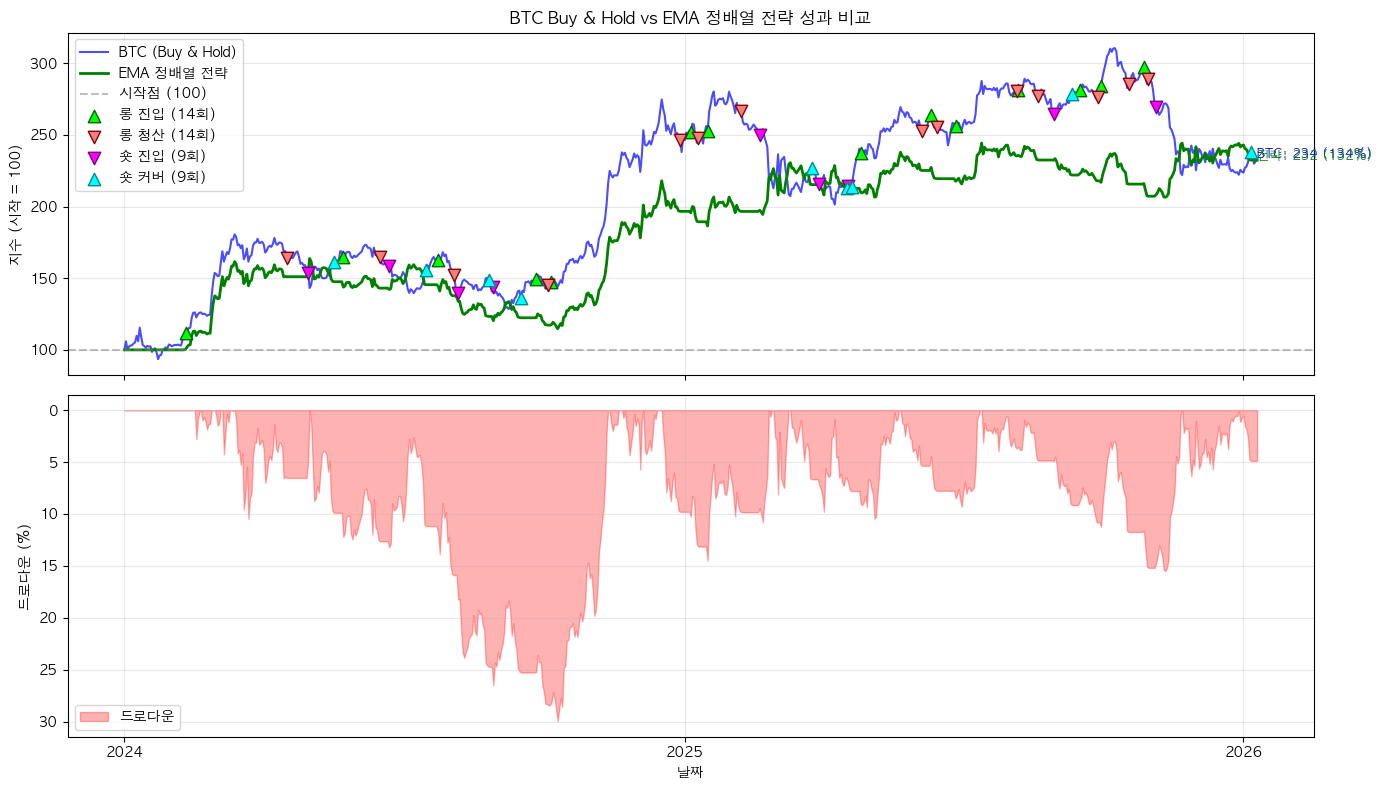

In [6]:
# 포트폴리오 가치 변화 그래프
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd

# 한글 폰트 설정 (macOS)
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

# 위에서 실행한 결과 사용
strategy = result[0]

# Observer 데이터 추출
broker_obs = None
for obs in strategy.observers:
    obs_name = type(obs).__name__
    if 'Broker' in obs_name:
        broker_obs = obs
        break

# 날짜 데이터 추출
data_len = len(strategy.data)
dates = [strategy.data.datetime.date(-data_len + i + 1) for i in range(data_len)]

# 포트폴리오 가치 추출
values = []
if broker_obs is not None:
    value_array = broker_obs.lines.value.array
    values = list(value_array[:data_len])
else:
    values = [initial_cash] * data_len
    values[-1] = strategy.broker.getvalue()

# 지수화 (시작점 = 100)
btc_prices = df['close'].values
btc_indexed = (btc_prices / btc_prices[0]) * 100
portfolio_indexed = (np.array(values) / values[0]) * 100

# 드로다운 직접 계산
max_value = initial_cash
dd_values = []
for v in values:
    if v > max_value:
        max_value = v
    dd = (max_value - v) / max_value * 100 if max_value > 0 else 0
    dd_values.append(dd)

# 매수/매도 시점 추출 (4가지 액션 구분)
long_entry_dates, long_entry_prices = [], []  # 롱 진입
long_exit_dates, long_exit_prices = [], []  # 롱 청산
short_entry_dates, short_entry_prices = [], []  # 숏 진입
short_cover_dates, short_cover_prices = [], []  # 숏 커버

for trade in strategy.trade_history:
    trade_date = trade['date']
    trade_timestamp = pd.Timestamp(trade_date)

    if trade_timestamp in df.index:
        idx = df.index.get_loc(trade_timestamp)
        indexed_price = btc_indexed[idx]
    else:
        closest_idx = df.index.searchsorted(trade_timestamp)
        if closest_idx >= len(df):
            closest_idx = len(df) - 1
        indexed_price = btc_indexed[closest_idx]

    action = trade['action']
    if action == '롱 진입':
        long_entry_dates.append(trade_date)
        long_entry_prices.append(indexed_price)
    elif action == '롱 청산':
        long_exit_dates.append(trade_date)
        long_exit_prices.append(indexed_price)
    elif action == '숏 진입':
        short_entry_dates.append(trade_date)
        short_entry_prices.append(indexed_price)
    elif action == '숏 커버':
        short_cover_dates.append(trade_date)
        short_cover_prices.append(indexed_price)

# 그래프 그리기 (2개 subplot)
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# 1. BTC 가격 vs 포트폴리오 가치 (지수화)
ax1 = axes[0]
ax1.plot(df.index, btc_indexed, label='BTC (Buy & Hold)', color='blue', alpha=0.7)
ax1.plot(dates, portfolio_indexed, label='EMA 정배열 전략', color='green', linewidth=2)
ax1.axhline(y=100, color='gray', linestyle='--', alpha=0.5, label='시작점 (100)')

# 롱/숏 마커 표시 (4가지 색상)
if long_entry_dates:
    ax1.scatter(long_entry_dates, long_entry_prices, marker='^', color='lime', s=80,
                label=f'롱 진입 ({len(long_entry_dates)}회)', zorder=5, edgecolors='darkgreen', linewidths=1)
if long_exit_dates:
    ax1.scatter(long_exit_dates, long_exit_prices, marker='v', color='lightcoral', s=80,
                label=f'롱 청산 ({len(long_exit_dates)}회)', zorder=5, edgecolors='darkred', linewidths=1)
if short_entry_dates:
    ax1.scatter(short_entry_dates, short_entry_prices, marker='v', color='magenta', s=80,
                label=f'숏 진입 ({len(short_entry_dates)}회)', zorder=5, edgecolors='purple', linewidths=1)
if short_cover_dates:
    ax1.scatter(short_cover_dates, short_cover_prices, marker='^', color='cyan', s=80,
                label=f'숏 커버 ({len(short_cover_dates)}회)', zorder=5, edgecolors='darkcyan', linewidths=1)

ax1.set_ylabel('지수 (시작 = 100)')
ax1.set_title('BTC Buy & Hold vs EMA 정배열 전략 성과 비교')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# 최종 수익률 표시
btc_final = btc_indexed[-1]
portfolio_final = portfolio_indexed[-1]
ax1.annotate(f'BTC: {btc_final:.0f} ({(btc_final - 100):.0f}%)',
             xy=(df.index[-1], btc_final), fontsize=9, color='blue')
ax1.annotate(f'전략: {portfolio_final:.0f} ({(portfolio_final - 100):.0f}%)',
             xy=(df.index[-1], portfolio_final), fontsize=9, color='green')

# 2. 드로다운
ax2 = axes[1]
ax2.fill_between(dates, dd_values, 0, color='red', alpha=0.3, label='드로다운')
ax2.set_ylabel('드로다운 (%)')
ax2.set_xlabel('날짜')
ax2.legend(loc='lower left')
ax2.grid(True, alpha=0.3)
ax2.invert_yaxis()

# X축 날짜 포맷
ax2.xaxis.set_major_locator(mdates.YearLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.tight_layout()
plt.show()